In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [5]:
data = pd.read_json("user-wallet-transactions.json")
df = pd.DataFrame(data)

In [6]:
df.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [7]:
df.isnull().sum()

_id            0
userWallet     0
network        0
protocol       0
txHash         0
logId          0
timestamp      0
blockNumber    0
action         0
actionData     0
__v            0
createdAt      0
updatedAt      0
dtype: int64

In [8]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')>

In [9]:
df["userWallet"].head(3)

0    0x00000000001accfa9cef68cf5371a23025b6d4b6
1    0x000000000051d07a4fb3bd10121a343d85818da6
2    0x000000000096026fb41fc39f9875d164bd82e2dc
Name: userWallet, dtype: object

In [10]:
df["action"].value_counts()

action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

In [11]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [12]:
wallet_features = []

for wallet in df['userWallet'].unique():
    wallet_data = df[df['userWallet'] == wallet]
    action_counts = wallet_data['action'].value_counts()
    deposit_count = action_counts.get('deposit', 0)
    borrow_count = action_counts.get('borrow', 0)
    repay_count = action_counts.get('repay', 0)
    redeem_count = action_counts.get('redeemunderlying', 0)
    liquidation_count = action_counts.get('liquidationcall', 0)
    total_transactions = len(wallet_data)
    days_active = (wallet_data['timestamp'].max() - wallet_data['timestamp'].min()).days + 1
    transactions_per_day = total_transactions / days_active
    repay_ratio = repay_count / max(borrow_count, 1)
    liquidation_rate = liquidation_count / total_transactions
    unique_actions = len(action_counts)

    wallet_features.append({
        'wallet': wallet,
        'total_transactions': total_transactions,
        'deposit_count': deposit_count,
        'borrow_count': borrow_count,
        'repay_count': repay_count,
        'liquidation_count': liquidation_count,
        'repay_ratio': repay_ratio,
        'days_active': days_active,
        'transactions_per_day': transactions_per_day,
        'liquidation_rate': liquidation_rate,
        'unique_actions': unique_actions
    })


In [13]:
feature_df = pd.DataFrame(wallet_features)

In [14]:
feature_df.head()

,wallet,total_transactions,deposit_count,borrow_count,repay_count,liquidation_count,repay_ratio,days_active,transactions_per_day,liquidation_rate,unique_actions
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,0.000000,1,1.000000,0.0,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,0.000000,1,1.000000,0.0,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0.000000,8,0.250000,0.0,1
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,0.000000,130,0.130769,0.0,1
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,0.266667,133,3.000000,0.0,4


In [15]:
def calculate_score(row):
    return (
       row['repay_ratio'] * 300 +
        row['deposit_count'] * 10 +
        row['repay_count'] * 10 +
        - row['liquidation_count'] * 100 +
        - row['liquidation_rate'] * 500 +
        row['transactions_per_day'] * 10 +
        row['unique_actions'] * 20 +
        row['days_active'] * 2
    )
feature_df["score"] = feature_df.apply(calculate_score,axis=1)

In [16]:
feature_df["score"]= np.clip(feature_df["score"],0,1000)

In [17]:
feature_df.drop(columns="wallet",axis=1,inplace=True)
feature_df.head()

,total_transactions,deposit_count,borrow_count,repay_count,liquidation_count,repay_ratio,days_active,transactions_per_day,liquidation_rate,unique_actions,score
0,1,1,0,0,0,0.000000,1,1.000000,0.0,1,42.000000
1,1,1,0,0,0,0.000000,1,1.000000,0.0,1,42.000000
2,2,2,0,0,0,0.000000,8,0.250000,0.0,1,58.500000
3,17,0,0,0,0,0.000000,130,0.130769,0.0,1,281.307692
4,399,250,15,4,0,0.266667,133,3.000000,0.0,4,1000.000000


In [18]:

X = feature_df.iloc[:,:-1]
y = feature_df["score"]

In [19]:
X

,total_transactions,deposit_count,borrow_count,repay_count,liquidation_count,repay_ratio,days_active,transactions_per_day,liquidation_rate,unique_actions
0,1,1,0,0,0,0.000000,1,1.000000,0.0,1
1,1,1,0,0,0,0.000000,1,1.000000,0.0,1
2,2,2,0,0,0,0.000000,8,0.250000,0.0,1
3,17,0,0,0,0,0.000000,130,0.130769,0.0,1
4,399,250,15,4,0,0.266667,133,3.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...
3492,1,1,0,0,0,0.000000,1,1.000000,0.0,1
3493,7,4,1,0,0,0.000000,1,7.000000,0.0,3
3494,5,1,0,0,0,0.000000,1,5.000000,0.0,2
3495,22,13,2,2,0,1.000000,32,0.687500,0.0,4


In [20]:
scaler= StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,random_state=42,test_size=0.2)


In [22]:
model = RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [23]:
model_pred = model.predict(X_test)

In [24]:
print(r2_score(y_test,model_pred))

0.9780424633949064


In [25]:
feature_df["predicted_score"] = model.predict(X_scaled)
feature_df["predicted_score"] = np.clip(feature_df["predicted_score"],0,1000)

In [26]:
def label_score(score):
    if score >=900:
        return "Excellent"
    elif score >=700:
        return "Good"
    elif score >=500:
        return "Fair"
    elif score >=200:
        return "Poor"
    else:
        return "Very Poor"
feature_df["label"] = feature_df["predicted_score"].apply(label_score)

In [27]:
feature_df.head()

,total_transactions,deposit_count,borrow_count,repay_count,liquidation_count,repay_ratio,days_active,transactions_per_day,liquidation_rate,unique_actions,score,predicted_score,label
0,1,1,0,0,0,0.000000,1,1.000000,0.0,1,42.000000,42.000000,Very Poor
1,1,1,0,0,0,0.000000,1,1.000000,0.0,1,42.000000,42.000000,Very Poor
2,2,2,0,0,0,0.000000,8,0.250000,0.0,1,58.500000,58.500000,Very Poor
3,17,0,0,0,0,0.000000,130,0.130769,0.0,1,281.307692,288.530204,Poor
4,399,250,15,4,0,0.266667,133,3.000000,0.0,4,1000.000000,995.493312,Excellent


In [28]:
results = feature_df[['predicted_score', 'label']]
results.to_csv('credit_scores.csv', index=False)
print('Saved Successfully')

Saved Successfully


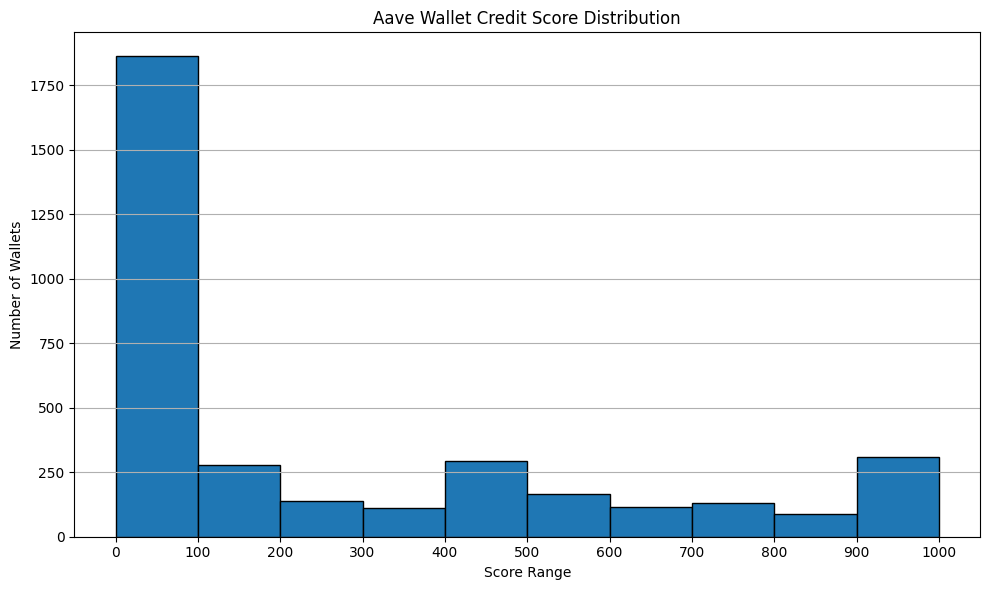

In [29]:
results = pd.read_csv('credit_scores.csv')
bins = range(0, 1100, 100)
plt.figure(figsize=(10,6))
plt.hist(results['predicted_score'], bins=bins, edgecolor='black')
plt.title('Aave Wallet Credit Score Distribution')
plt.xlabel('Score Range')
plt.ylabel('Number of Wallets')
plt.xticks(bins)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('score_distribution.png')
plt.show()
